# Fine-tuning GPT-2 for text classification
Stefan/Yuzhao Heng
Since Wed. Feb. 9th, 2022


Reproduce the results in paper [Zero-shot Text Classification With Generative Language Models](https://arxiv.org/abs/1912.10165),
since the authors didn't release the code.

Serve as infrastructure and baseline for project on efficient and accurate encoder for text classification with many labels.


## Notebook Setup



In [32]:
%load_ext autoreload
%autoreload 2



[autoreload of torch.nn.functional failed: Traceback (most recent call last):
  File "/Users/stefanh/opt/anaconda3/envs/unified-encoder/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/stefanh/opt/anaconda3/envs/unified-encoder/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/stefanh/opt/anaconda3/envs/unified-encoder/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/stefanh/opt/anaconda3/envs/unified-encoder/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/stefanh/opt/anaconda3/envs/unified-encoder/lib/p

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Colab Setup



In [33]:
import os
import sys


if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    ! pip3 install sty icecream transformers datasets

    # base_path = '/content/drive/My Drive//Research/'
    # os.chdir(os.path.join(base_path, 'Unified Encoder/Unified-Encoder'))

    sys.path.append(os.path.join('drive', 'My Drive', 'Research', 'Unified Encoder', 'Unified-Encoder'))


from unified_encoder.util import *
print(PATH_BASE)  # Sanity check, should be the path appended if Colab



/Users/stefanh/Documents/UMich/Research/Clarity Lab/Unified Encoder


## Setup



In [34]:
import random

import numpy as np
import torch
import transformers
from icecream import ic

from unified_encoder.baseline import gpt2


rcParams['figure.dpi'] = 200
rcParams['font.size'] = 6



## Seed setup



In [35]:
if torch.cuda.is_available():
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # Required for some CuBLAS operations
    ! echo $CUBLAS_WORKSPACE_CONFIG


seed = config('random-seed')
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)
transformers.set_seed(seed)



## Prep Model & Dataset for training


In [36]:
nm, n = 'debug', 8
# nm, n = 'debug-large', 128
model, tokenizer, data_collator, train_args, dset_tr, dset_vl, trainer = gpt2.get_all_setup(
    nm, n_sample=n, random_seed=seed
)



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'ZsGPT2Tokenizer'.
Using custom data configuration default
Reusing dataset ag_news (/Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Using custom data configuration default
Reusing dataset ag_news (/Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
Token indices sequence length is longer than the specified maximum sequence length for this model (29 > 4). Running this sequence through the model will result in indexing errors


  0%|          | 0/1 [00:00<?, ?ba/s]

## Train


2022-02-15 21:51:49| [GPT-2 Training]::on_train_begin::gpt2.py:441, INFO - Training started with {#data: 8, model size: 4, learning rate: 0.0001, batch size: 4, #epochs: 4}
2022-02-15 21:51:50| [GPT-2 Training]::log_update::gpt2.py:474, INFO - step=   0, epoch=  0.00, train_loss=10.4523, eval_loss=10.5949, train_acc=  0.00, eval_acc=  0.00
2022-02-15 21:51:52| [GPT-2 Training]::log_update::gpt2.py:474, INFO - step=   1, epoch=  0.50, train_loss=10.4523, eval_loss= 6.7241, train_acc=  0.00, eval_acc=  0.00
2022-02-15 21:51:54| [GPT-2 Training]::log_update::gpt2.py:474, INFO - step=   2, epoch=  1.00, train_loss= 7.1050, eval_loss= 5.6400, train_acc=  0.00, eval_acc=  9.38
2022-02-15 21:51:55| [GPT-2 Training]::log_update::gpt2.py:474, INFO - step=   3, epoch=  1.50, train_loss= 3.0603, eval_loss= 5.4367, train_acc=  6.25, eval_acc=  9.38
2022-02-15 21:51:57| [GPT-2 Training]::log_update::gpt2.py:474, INFO - step=   4, epoch=  2.00, train_loss= 5.0912, eval_loss= 4.9143, train_acc= 12.50

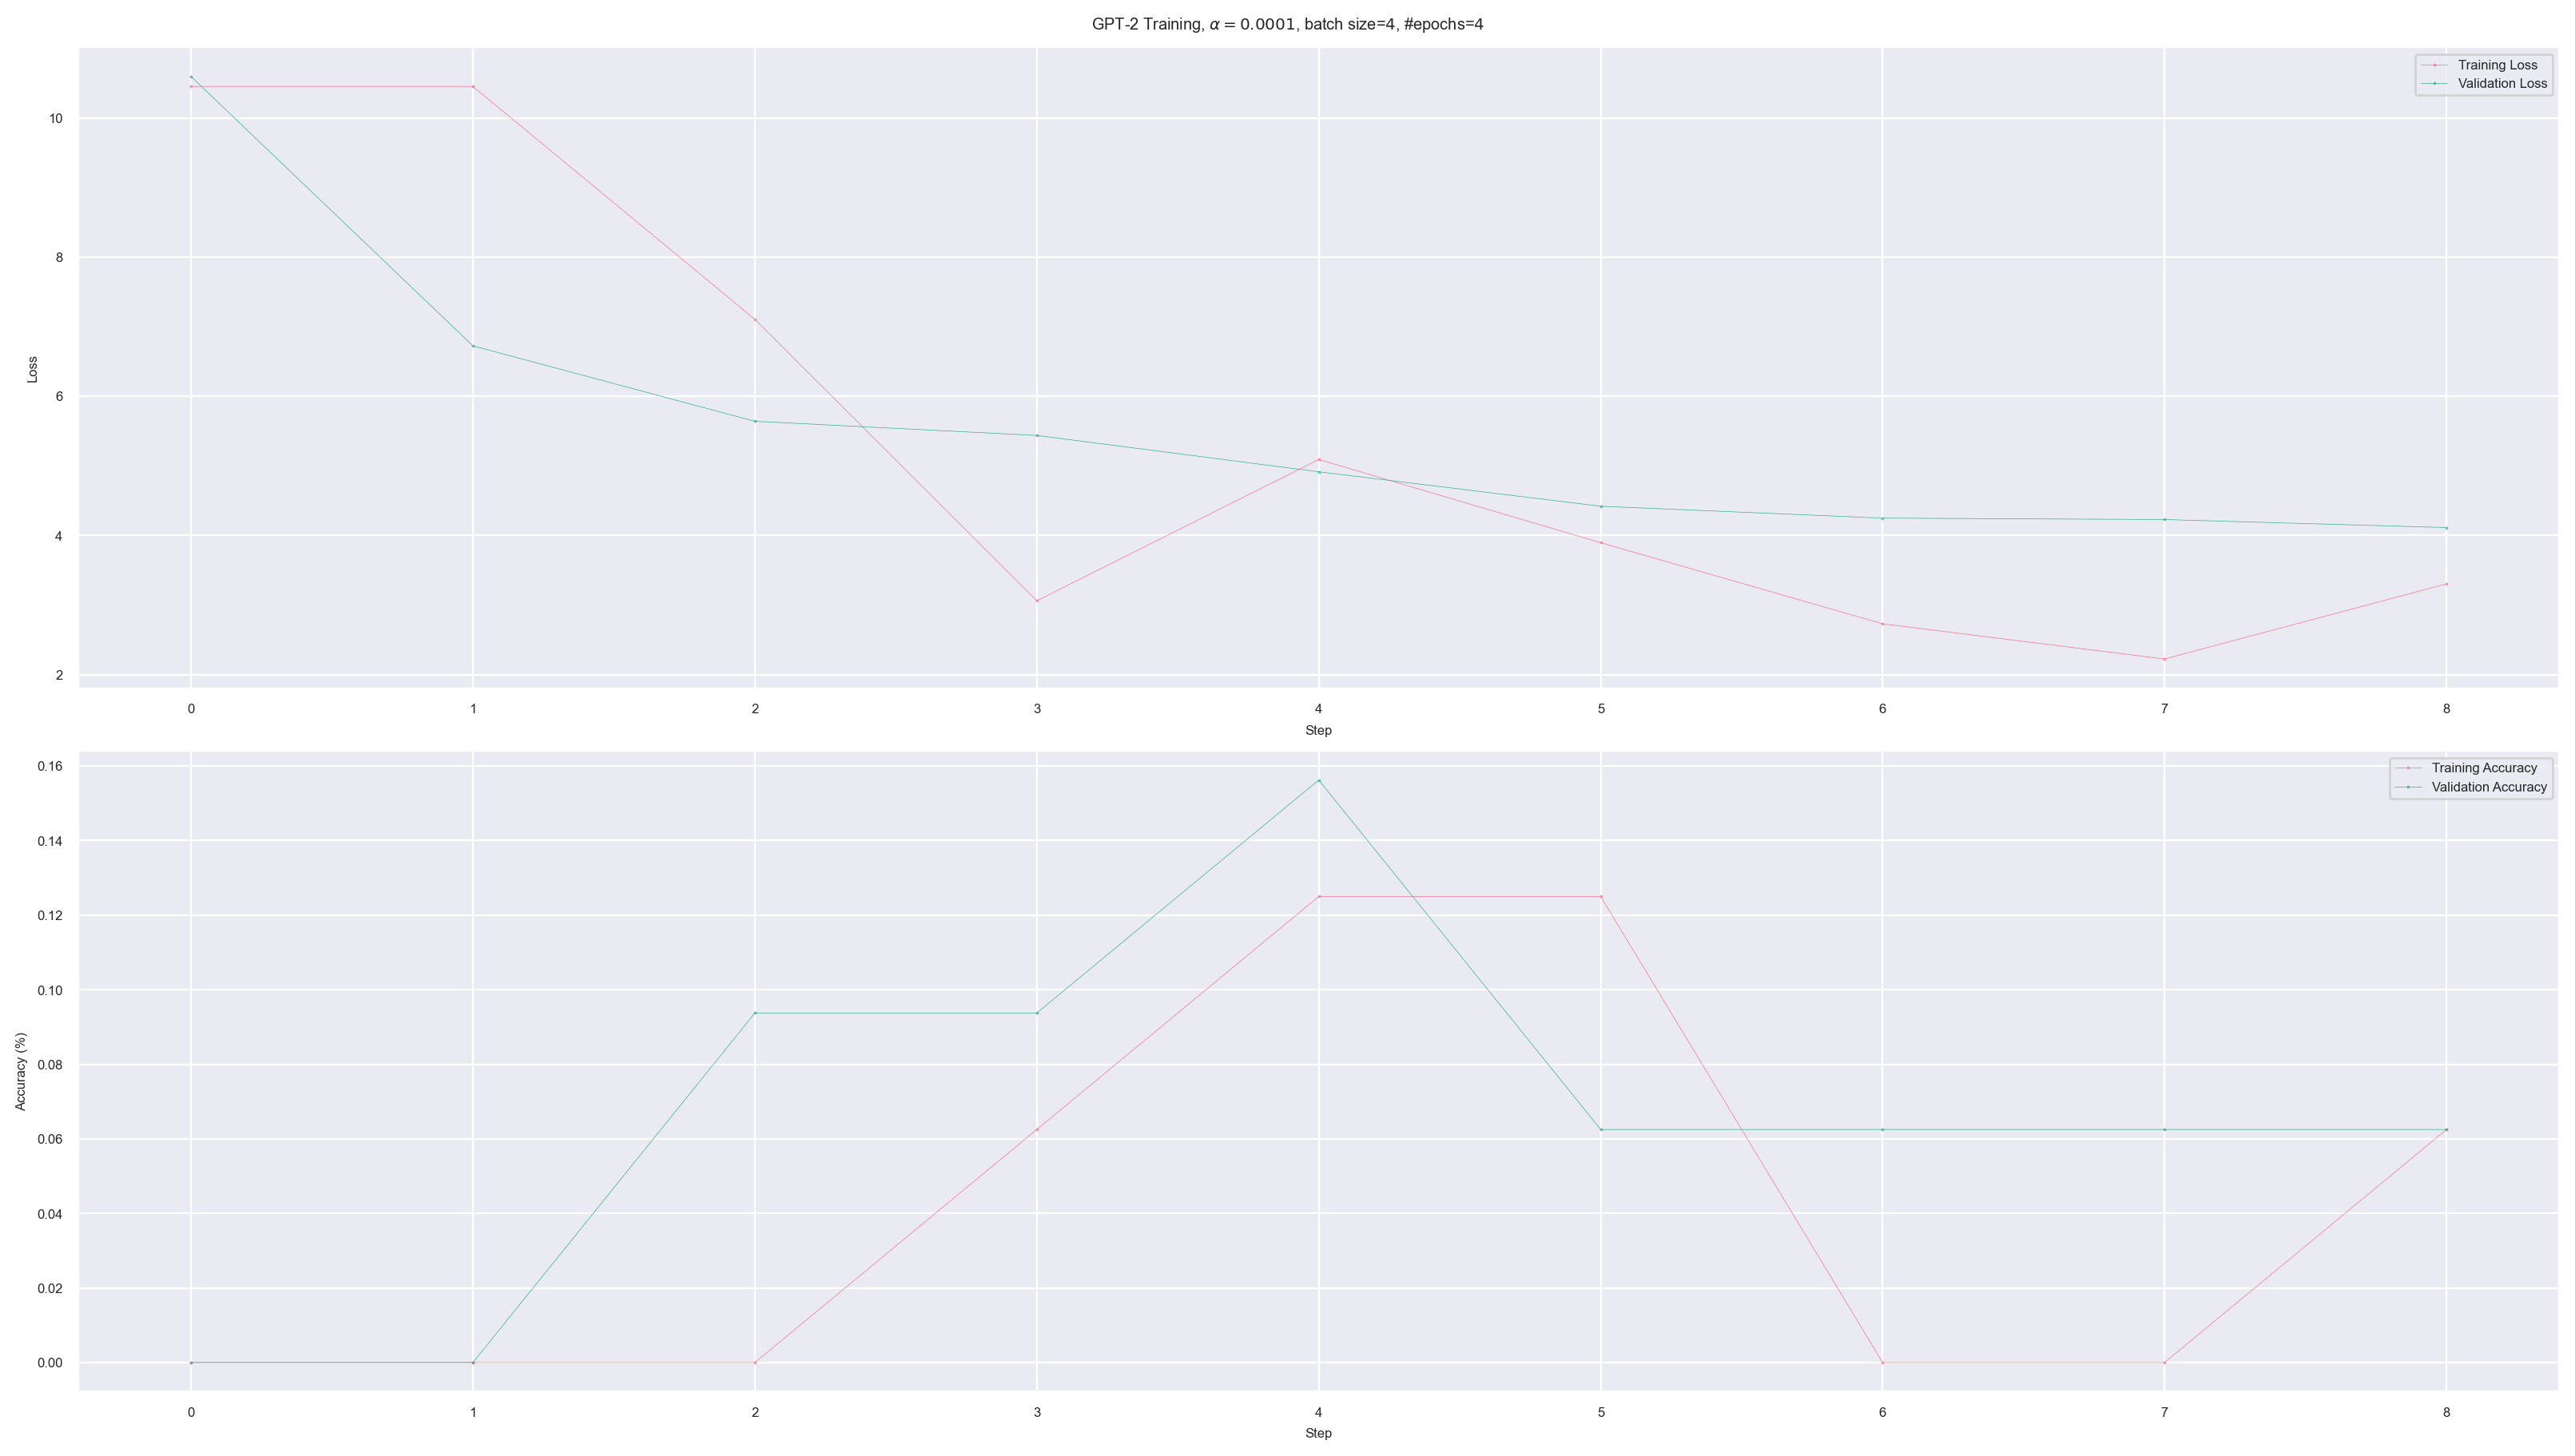

In [37]:
trainer.train()
trainer.save_model(os.path.join(trainer.args.output_dir, now(sep='-')))



## Evaluate


In [38]:
trainer.evaluate()



2022-02-15 21:52:10| [GPT-2 Training]::on_log::gpt2.py:533, INFO - {eval_loss: 4.112923622131348, eval_accuracy: 0.0625, eval_runtime: 0.3744, eval_samples_per_second: 21.366, eval_steps_per_second: 5.341, epoch: 4.0}


{'eval_loss': 4.112923622131348,
 'eval_accuracy': 0.0625,
 'eval_runtime': 0.3744,
 'eval_samples_per_second': 21.366,
 'eval_steps_per_second': 5.341,
 'epoch': 4.0}